In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

### Designing the Kalman Filter

Modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

In [44]:
def parameters():
    A = np.identity(4)
    A[0,2], A[1,3] = 1,1                              # VERIFY THIS!!! (Time steps are not included!)

    B = np.array([[1/2,0],[0,1/2],[1,0],[0,1]])     # VERIFY THIS!!!  (Should be 1/2 * a * t^2 )

    meu_q = np.zeros((4))
    cov_q = np.identity(4)
    cov_q[2,2],cov_q[3,3] = 0.0001,0.0001
    # To genrate => ep = np.random.multivariate_normal(meu_q,cov_q,N)

    C = np.array([[1,0,0,0],[0,1,0,0]])
    meu_r = np.zeros((2))
    cov_r = 100*np.identity(2)
    # To genrate => ep = np.random.multivariate_normal(meu_r,cov_r,N)

    T = 200     # Total time steps
    
    return (A,B,meu_q,cov_q,C,meu_r,cov_r,T)

# A,B,meu_q,cov_q,C,meu_r,cov_r,T = parameters()
# params = parameters()

### 2. (a)  Simulate motion and sensor model, and plot the actual and observed trajectory.

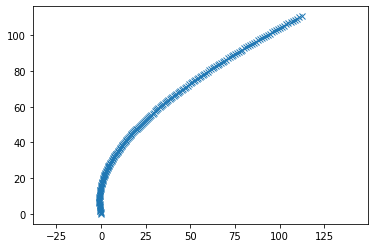

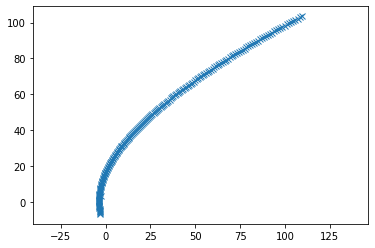

In [50]:
def zero_initializer():
    del_xy = np.zeros((2))
    X = np.zeros((4))
    return(del_xy,X)


def time_series(U, X_init , params):
    
    A,B,meu_q,cov_q,C,meu_r,cov_r,T = params

    # Assuming deltax and deltay are 0         # CAN/DO WE MAKE THIS ASSUMPTION
    del_xy = U
    
    ep_q = np.random.multivariate_normal(meu_q,cov_q)
    ep_r = np.random.multivariate_normal(meu_r,cov_r)
    
    X = np.zeros((T,4))
    X[0,:] = X_init
    X_obs = np.zeros((T,2))
    X_obs[0,:] = np.dot(C,X[0,:]) + ep_r
    
    
    
    X_obs[0,:] = np.random.multivariate_normal(meu_r,cov_r)


    for i in range(1,T):
        
        X[i,:] = np.dot(A,X[i-1,:])+np.dot(B,del_xy) + ep_q

        X_obs[i,:] = np.dot(C,X[i,:]) + ep_r
    
    return (X,X_obs)

params = parameters()
del_xy,X_init = zero_initializer()
X,X_obs = time_series(del_xy,X_init,params)

def plotter(X,X_obs):

    x, y = X[:,0],X[:,1]
    plt.plot(x, y, 'x')
    plt.axis('equal')
    plt.show()

    xd, yd = X_obs[:,0],X_obs[:,1]
    plt.plot(xd, yd, 'x')
    plt.axis('equal')
    plt.show()

plotter(X,X_obs)

### 2.(b) Estimation of Vehicle state
We use Kalman filter form of Baye's filter for the implementing the estimation of the vehicle's state.

As mentioned before, modelling as,

$$ X_{t+1} = A_{t}X_{t} + B_{t}U_{t} + \epsilon_{t} $$
$$ Z_t = C_{t}X_{t} + \delta_{t} $$

In [ ]:
X_init = np.array([10,10,1,1])
